<a href="https://colab.research.google.com/github/yoonmato/mood-equalizer/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 데이터셋 다운로드

In [18]:
!pip install kaggle    #colab에서 리눅스 명령어를 사용할 때는 !을 붙여준다.

from google.colab import files
files.upload()    		#kaggle.json upload

#colab 내 kaggle 디렉토리 생성
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

#permission warning 방지
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -q gtzan-dataset-music-genre-classification.zip

Saving kaggle.json to kaggle (2).json
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace Data/features_3_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#2. 오디오 파일 이해하기 : 숫자로 이루어짐

2-1. 기본값 확인

In [4]:
import librosa

y , sr = librosa.load('Data/genres_original/reggae/reggae.00036.wav') # librosa.load() : 오디오 파일을 로드한다.

print(y)
print(len(y))
print('Sampling rate (Hz): %d' %sr)
print('Audio length (seconds): %.2f' % (len(y) / sr)) #음악의 길이(초) = 음파의 길이/Sampling rate

[0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388]
661794
Sampling rate (Hz): 22050
Audio length (seconds): 30.01


2-2. 음악 들어보기

In [5]:
import IPython.display as ipd
ipd.Audio(y, rate=sr)

2-3. 2D 음파 그래프

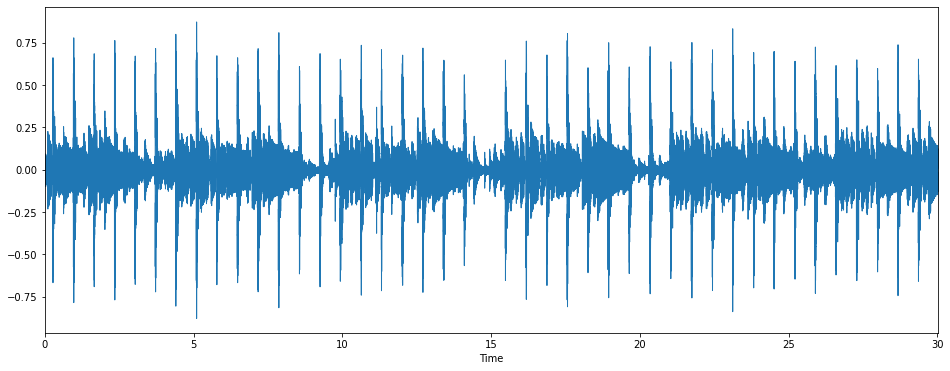

In [6]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize =(16,6))
librosa.display.waveplot(y=y,sr=sr)
plt.show()

2-4. Fourier Transform(푸리에 변환)

(1025, 1293)


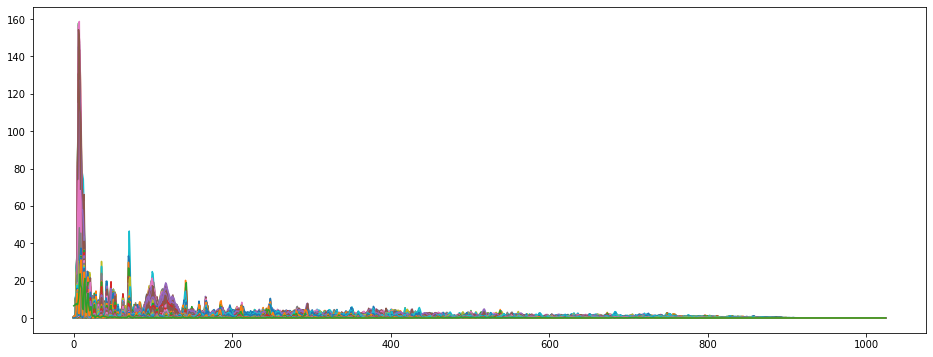

In [7]:
import numpy as np

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) #n_fft : window size / 이 때, 음성의 길이를 얼마만큼으로 자를 것인가? 를 window라고 부른다.


print(D.shape)

plt.figure(figsize=(16,6))
plt.plot(D)
plt.show()

2-5. Spectogram


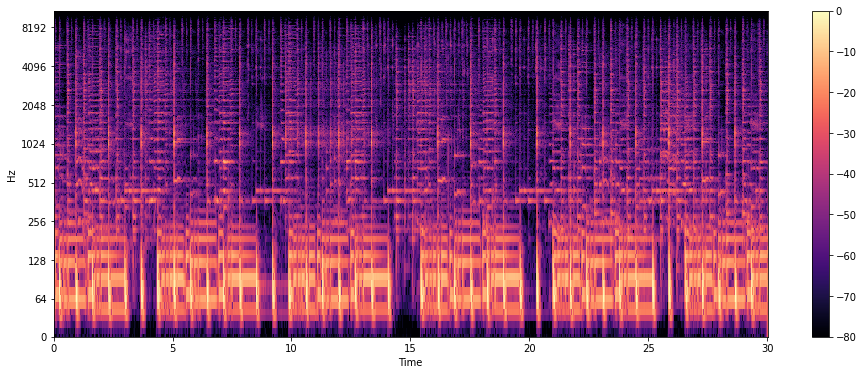

In [8]:
DB = librosa.amplitude_to_db(D, ref=np.max) #amplitude(진폭) -> DB(데시벨)로 바꿔라

plt.figure(figsize=(16,6))
librosa.display.specshow(DB,sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

2-6. Mel Spectogram

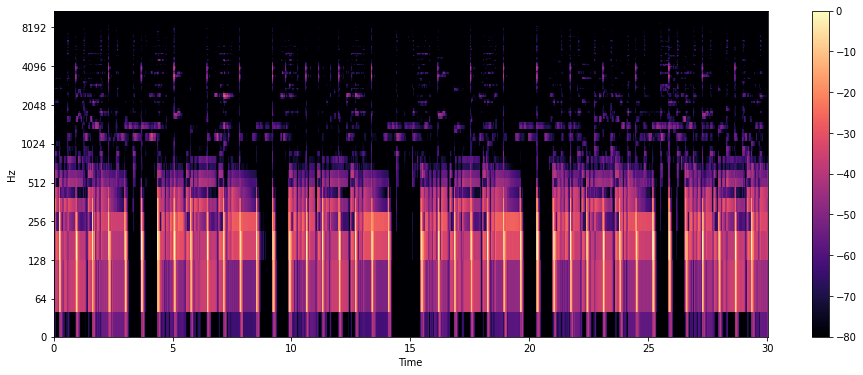

In [9]:
S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr,hop_length=512, x_axis='time',y_axis='log')
plt.colorbar()
plt.show()

2-7. 레게 vs 클래식 Mel Spectogram


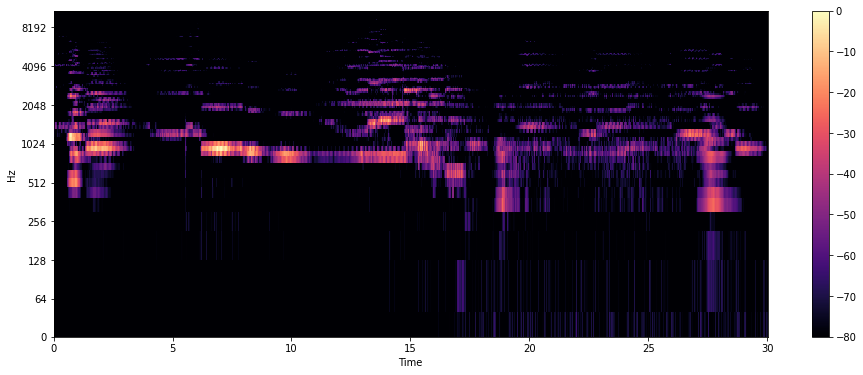

In [10]:
y, sr = librosa.load('Data/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr,hop_length=512, x_axis='time',y_axis='log')
plt.colorbar()
plt.show()

#3. 오디오 특성 추출
3-1 Tempo(BPM)

In [11]:
tempo , _ = librosa.beat.beat_track(y,sr=sr)     
print(tempo)

107.666015625


3-2. Zero Crossing Rate

In [12]:
zero_crossings = librosa.zero_crossings(y, pad=False)

print(zero_crossings)
print(sum(zero_crossings)) # 음 <-> 양 이동한 횟수

[False False False ... False False False]
39405


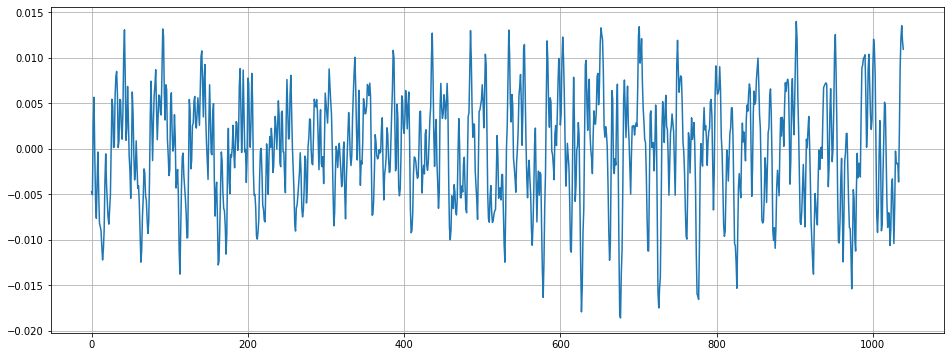

In [13]:
n0 = 8000
n1 = 9040

plt.figure(figsize=(16,6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()

In [14]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False) #n0 ~ n1 사이 zero crossings 
print(sum(zero_crossings))

183


3-3. Harmonic and Percussive Components

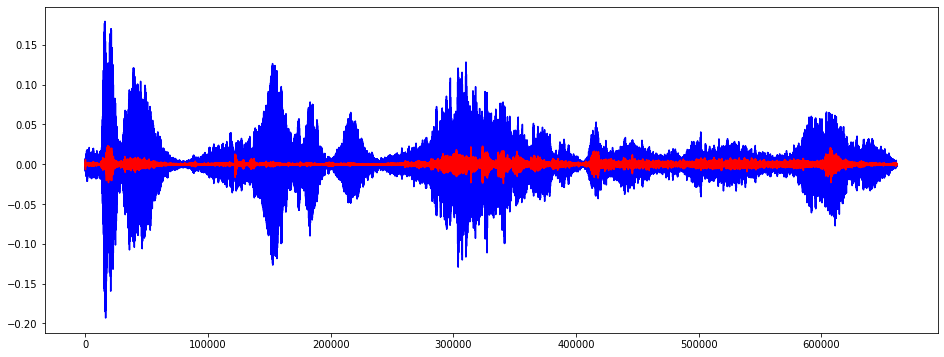

In [15]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16,6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

3-4.Spectral Centroid

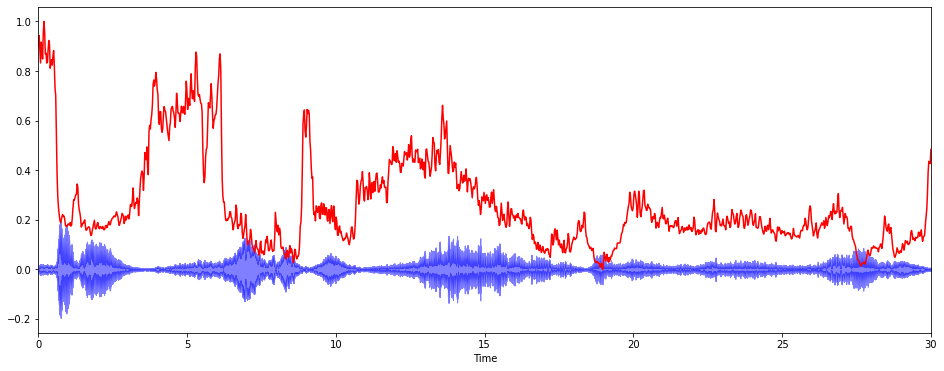

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

#Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)    #sk.minmax_scale() : 최대 최소를 0 ~ 1 로 맞춰준다.

plt.figure(figsize=(16,6))
librosa.display.waveplot(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

3-5. Spectral Rolloff

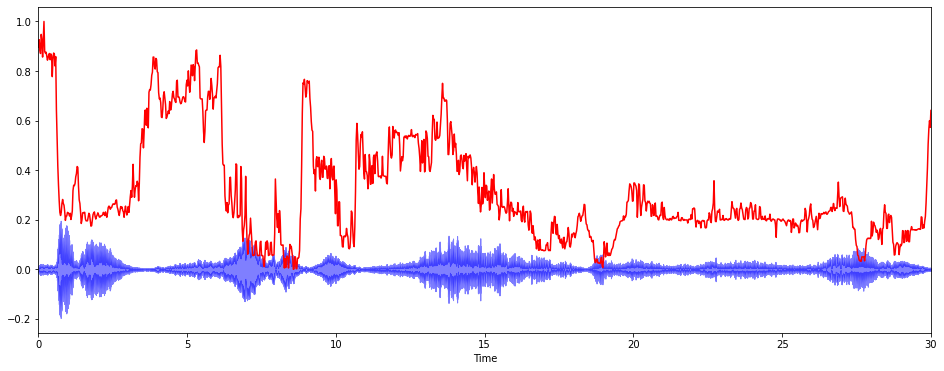

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]

plt.figure(figsize=(16,6))
librosa.display.waveplot(y,sr=sr,alpha=0.5,color='b')
plt.plot(t, normalize(spectral_rolloff),color='r')
plt.show()

3-6. Mel-Frequency Cepstral Coefficients(MFCCs)

mean: 0.48
var: 0.04


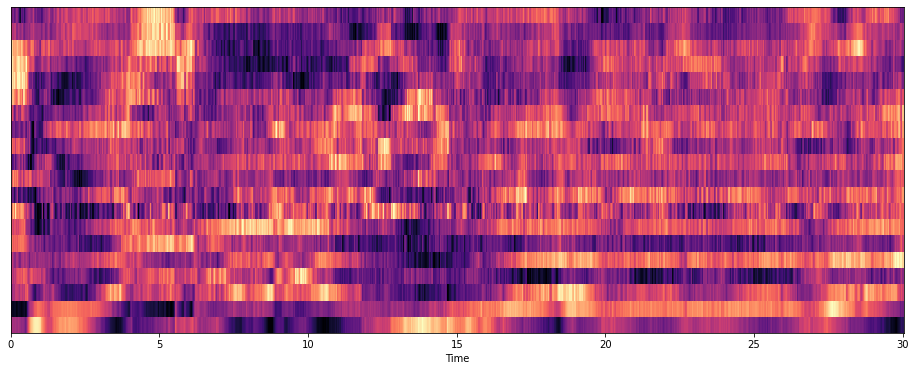

In [ ]:
mfccs = librosa.feature.mfcc(y, sr=sr)
mfccs = normalize(mfccs,axis=1)

print('mean: %.2f' % mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16,6))
librosa.display.specshow(mfccs,sr=sr, x_axis='time')
plt.show()

3-7. Chroma Frequencies

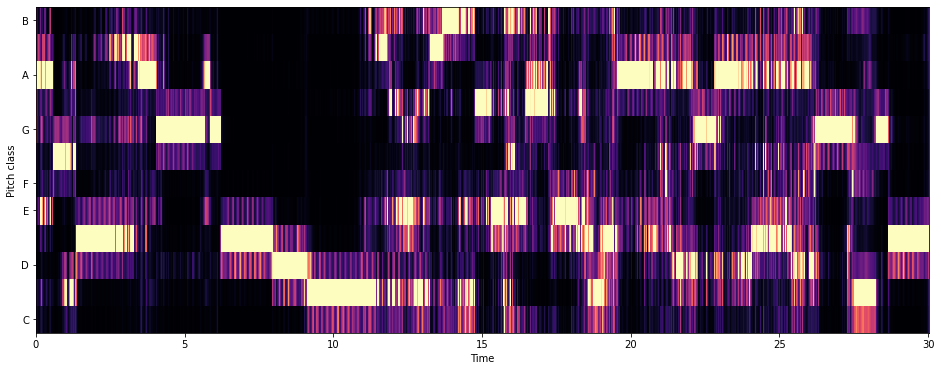

In [ ]:
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)

plt.figure(figsize=(16,6))
librosa.display.specshow(chromagram,x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

#4. 음악장르 분류 알고리즘
4-1. 데이터 로드

In [19]:
import pandas as pd

df = pd.read_csv('Data/features_3_sec.csv')

df.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

In [64]:
#/Users/tomato/Desktop/testdata/DESIGNER.mp3
from google.colab import files
uploaded = files.upload()

Saving DESIGNER(30).mp3 to DESIGNER(30) (1).mp3


In [67]:
import pydub
sound = pydub.AudioSegment.from_mp3("DESIGNER(30) (1).mp3")
sound.export("DESIGNER(30).wav", format="wav")

<_io.BufferedRandom name='DESIGNER(30).wav'>

In [68]:
!ls

 Data			 DESIGNER.wav
'DESIGNER (1).mp3'	 gtzan-dataset-music-genre-classification.zip
'DESIGNER(30) (1).mp3'	'kaggle (1).json'
'DESIGNER(30).mp3'	'kaggle (2).json'
'DESIGNER(30).wav'	 kaggle.json
 DESIGNER.mp3		 sample_data


In [180]:
test_y , test_sr = librosa.load('DESIGNER(30).wav') # librosa.load() : 오디오 파일을 로드한다.

print(test_y)
print(len(test_y))
print('Sampling rate (Hz): %d' %test_sr)
print('Audio length (seconds): %.2f' % (len(test_y) / test_sr)) #음악의 길이(초) = 음파의 길이/Sampling rate

ipd.Audio(test_y, rate=test_sr)

[-7.6310869e-07 -6.8413169e-06 -7.9617007e-07 ...  7.0337273e-02
  9.1221817e-02  0.0000000e+00]
662424
Sampling rate (Hz): 22050
Audio length (seconds): 30.04


In [62]:
!ls

 Data		     gtzan-dataset-music-genre-classification.zip
'DESIGNER (1).mp3'  'kaggle (1).json'
'DESIGNER(30).mp3'  'kaggle (2).json'
'DESIGNER(30).wav'   kaggle.json
 DESIGNER.mp3	     sample_data
 DESIGNER.wav


In [252]:
#length

test_y , test_sr = librosa.load('DESIGNER(30).wav') # librosa.load() : 오디오 파일을 로드한다.

print(test_y)
print(len(test_y))
print('Sampling rate (Hz): %d' %test_sr)
print('Audio length (seconds): %.2f' % (len(test_y) / test_sr)) #음악의 길이(초) = 음파의 길이/Sampling rate
data={}
data['filename']='DESIGNER(30).wav'
data['length']=len(test_y)
# data = {'filename':'DESIGNER(30).wav','length':len(y)}
# print(data)

[-7.6310869e-07 -6.8413169e-06 -7.9617007e-07 ...  7.0337273e-02
  9.1221817e-02  0.0000000e+00]
662424
Sampling rate (Hz): 22050
Audio length (seconds): 30.04


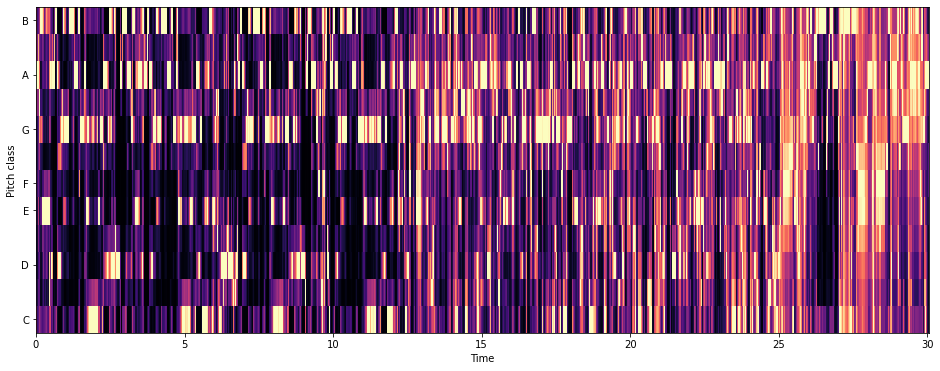

0.38232148
0.0954587
{'filename': 'DESIGNER(30).wav', 'length': 662424, 'chroma_stft_mean': 0.38232148, 'chroma_stft_var': 0.0954587}


In [253]:
#chromagram - mean, var

chromagram = librosa.feature.chroma_stft(test_y, sr=test_sr, hop_length=512)

plt.figure(figsize=(16,6))
librosa.display.specshow(chromagram,x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

print(chromagram.mean())
print(chromagram.var())
data['chroma_stft_mean']=chromagram.mean()
data['chroma_stft_var']=chromagram.var()

# data.append('chroma_stft_var':chromagram.var())

print(data)

In [254]:
#rms mean var

rms = librosa.feature.rms(y=test_y)

print(rms.mean())
print(rms.var())

data['rms_mean']=rms.mean()
data['rms_var']=rms.var()

0.07436205
0.0052268556


In [255]:
#spectral_centroid mean var

spectral_centroids = librosa.feature.spectral_centroid(test_y, sr=test_sr)
print(spectral_centroids.mean())
print(spectral_centroids.var())

data['spectral_centroid_mean']=spectral_centroids.mean()
data['spectral_centroid_var']=spectral_centroids.var()




2284.7181492048985
1205322.6783649118


In [256]:
#spectral_bandwidth mean var

spectral_bandwidth = librosa.feature.spectral_bandwidth(y=test_y,sr=test_sr)

print(spectral_bandwidth.mean())
print(spectral_bandwidth.var())

data['spectral_bandwidth_mean']=spectral_bandwidth.mean()
data['spectral_bandwidth_var']=spectral_bandwidth.var()

2205.5971413274906
516232.5197066321


In [257]:
#rolloff mean var

spectral_rolloff = librosa.feature.spectral_rolloff(test_y, sr=test_sr)

print(spectral_rolloff.mean())
print(spectral_rolloff.var())

data['rolloff_mean']=spectral_rolloff.mean()
data['rolloff_var']=spectral_rolloff.var()


4450.009490164944
4920830.5099921925


In [258]:
#zero crossing rate mean var

zero_crossings = librosa.zero_crossings(test_y, pad=False)

print(zero_crossings.mean())
print(zero_crossings.var())

data['zero_crossing_rate_mean']=zero_crossings.mean()
data['zero_crossing_rate_var']=zero_crossings.var()

0.10419761361303334
0.09334047093038236


In [259]:
# harm. perc mean, var
y_harm, y_perc = librosa.effects.hpss(test_y)

print(y_harm.mean())
print(y_harm.var())
print(y_perc.mean())
print(y_perc.var())

data['harmony_mean']=y_harm.mean()
data['harmony_var']=y_harm.var()
data['perceptr_mean']=y_perc.mean()
data['perceptr_var']=y_perc.var()

-2.0311696e-05
0.006039639
-0.00013229784
0.0030350608


In [260]:
#tempo

tempo , _ = librosa.beat.beat_track(test_y,sr=test_sr)     
print(tempo)

data['tempo']=tempo

75.99954044117646


In [261]:
#mfcc var mean

mfccs = librosa.feature.mfcc(test_y, sr=test_sr)
# mfccs = normalize(mfccs,axis=1)
for i in range(0,len(mfccs)):
  # print('mean: %.2f' % mfccs[i].mean())
  # print('var: %.2f' % mfccs[i].var())
  a = 'mfcc'
  a = a+str(i+1)
  keys = {a+'_mean':mfccs[i].mean(),a+'_var':mfccs[i].var()}
  data.update(keys)

In [263]:
data['label']='hiphop'
print(data)

{'filename': 'DESIGNER(30).wav', 'length': 662424, 'chroma_stft_mean': 0.38232148, 'chroma_stft_var': 0.0954587, 'rms_mean': 0.07436205, 'rms_var': 0.0052268556, 'spectral_centroid_mean': 2284.7181492048985, 'spectral_centroid_var': 1205322.6783649118, 'spectral_bandwidth_mean': 2205.5971413274906, 'spectral_bandwidth_var': 516232.5197066321, 'rolloff_mean': 4450.009490164944, 'rolloff_var': 4920830.5099921925, 'zero_crossing_rate_mean': 0.10419761361303334, 'zero_crossing_rate_var': 0.09334047093038236, 'harmony_mean': -2.0311696e-05, 'harmony_var': 0.006039639, 'perceptr_mean': -0.00013229784, 'perceptr_var': 0.0030350608, 'tempo': 75.99954044117646, 'mfcc1_mean': -215.98022, 'mfcc1_var': 13585.22, 'mfcc2_mean': 79.30001, 'mfcc2_var': 1303.7382, 'mfcc3_mean': -8.410832, 'mfcc3_var': 814.7585, 'mfcc4_mean': 1.9858677, 'mfcc4_var': 1248.0298, 'mfcc5_mean': -6.084306, 'mfcc5_var': 365.92917, 'mfcc6_mean': -6.8206053, 'mfcc6_var': 344.135, 'mfcc7_mean': -3.047783, 'mfcc7_var': 317.24136,

# 러닝


In [270]:
import pandas as pd

df = pd.read_csv('Data/features_3_sec.csv')

val = data.values()
print(val)
df.loc[9990]=val
# df.append(data,ignore_index=True)

print(df)

dict_values(['DESIGNER(30).wav', 662424, 0.38232148, 0.0954587, 0.07436205, 0.0052268556, 2284.7181492048985, 1205322.6783649118, 2205.5971413274906, 516232.5197066321, 4450.009490164944, 4920830.5099921925, 0.10419761361303334, 0.09334047093038236, -2.0311696e-05, 0.006039639, -0.00013229784, 0.0030350608, 75.99954044117646, -215.98022, 13585.22, 79.30001, 1303.7382, -8.410832, 814.7585, 1.9858677, 1248.0298, -6.084306, 365.92917, -6.8206053, 344.135, -3.047783, 317.24136, 5.423591, 288.42157, -0.80470526, 219.9504, 2.846965, 275.93387, -8.270861, 199.27394, -7.9479375, 229.52449, -2.9365537, 175.22853, 1.2815353, 176.21666, 2.378578, 140.0872, 2.0658047, 109.26682, 1.9672195, 68.5236, 5.647073, 77.58941, -1.9718792, 86.41828, 3.8958664, 72.554886, 'hiphop'])
               filename  length  ...  mfcc20_var   label
0     blues.00000.0.wav   66149  ...   43.771767   blues
1     blues.00000.1.wav   66149  ...   59.943081   blues
2     blues.00000.2.wav   66149  ...   33.105122   blues
3

In [286]:
import sklearn

X = df.drop(columns=['filename','length','label']) 
y = df['label'] #장르명

scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns=X.columns)
print(X)
print()
test_X = X.iloc[9990]
# # print(test_X)
# X = X.drop(index=9990)
print(X)

print(test_X)

      chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var
0             0.355399         0.716757  ...     0.506746    0.047781
1             0.367322         0.670347  ...     0.593029    0.065548
2             0.373159         0.728067  ...     0.546264    0.036062
3             0.399349         0.677066  ...     0.562204    0.034873
4             0.355668         0.689113  ...     0.517913    0.031713
...                ...              ...  ...          ...         ...
9986          0.413243         0.637013  ...     0.516365    0.020232
9987          0.374196         0.697548  ...     0.505937    0.045380
9988          0.436537         0.657745  ...     0.519900    0.013740
9989          0.408151         0.676143  ...     0.461372    0.034548
9990          0.428433         0.758514  ...     0.565998    0.079404

[9991 rows x 57 columns]

      chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var
0             0.355399         0.716757  ...     0.506746    0.

In [287]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=2021)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7992, 57) (7992,)
(1999, 57) (1999,)


In [288]:
from xgboost import XGBClassifier #xgboost 모델이 좋다길래 ..!!
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05) #1000개의 가지? epoch? , 0.05 학습률
xgb.fit(X_train, y_train) #학습

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [293]:
y_preds = xgb.predict(X_test) #검증

print('Accuracy: %.2f' % accuracy_score(y_test,y_preds))

test_X = pd.DataFrame(test_X)

print(test_X)
y_preds = xgb.predict(test_X)

Accuracy: 0.89
                             9990
chroma_stft_mean         0.428433
chroma_stft_var          0.758514
rms_mean                 0.166228
rms_var                  0.160257
spectral_centroid_mean   0.365333
spectral_centroid_var    0.251290
spectral_bandwidth_mean  0.531768
spectral_bandwidth_var   0.417396
rolloff_mean             0.429451
rolloff_var              0.378960
zero_crossing_rate_mean  0.271328
zero_crossing_rate_var   1.000000
harmony_mean             0.629172
harmony_var              0.047537
perceptr_mean            0.554781
perceptr_var             0.051547
tempo                    0.196483
mfcc1_mean               0.579384
mfcc1_var                0.301319
mfcc2_mean               0.347001
mfcc2_var                0.252634
mfcc3_mean               0.517781
mfcc3_var                0.196034
mfcc4_mean               0.297338
mfcc4_var                0.541033
mfcc5_mean               0.441322
mfcc5_var                0.229908
mfcc6_mean               0.314266

ValueError: ignored

In [237]:
# 내가 만든 testset

# print(data)
test_X = pd.DataFrame([data])
scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(test_X)

test_X = pd.DataFrame(np_scaled, columns=test_X.columns)
test_X.head()

chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var
0               0.0              0.0  ...          0.0         0.0

[1 rows x 57 columns]

In [238]:
X.head()

chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var
0          0.355399         0.716757  ...     0.506746    0.047781
1          0.367322         0.670347  ...     0.593029    0.065548
2          0.373159         0.728067  ...     0.546264    0.036062
3          0.399349         0.677066  ...     0.562204    0.034873
4          0.355668         0.689113  ...     0.517913    0.031713

[5 rows x 57 columns]